In [1]:
'''
Author: Chuyang Su cs4570@columbia.edu
Date: 2025-12-01 13:52:55
LastEditors: Schuyn 98257102+Schuyn@users.noreply.github.com
LastEditTime: 2025-12-01 14:04:44
FilePath: /Unsupervised-Machine-Learning-Final-Project/Code/main.ipynb
Description: 

'''
import sys
sys.path.append('.')

## Data Preprocessing

### 1. Split the data and fill the missing values.

In [ ]:
from Data_preprocessing import NBADataPreprocessor

# Initialize
preprocessor = NBADataPreprocessor(
    data_path='Data/nbaplayersdraft.csv',
    validation_year=2021
)

# Run pipeline
df_train, df_validation = preprocessor.run_pipeline(missing_value_strategy='drop_busts')

# Access separated features
feature_groups_train = preprocessor.separate_features(df_train)
X_modeling = feature_groups_train['modeling_numeric']
X_display = feature_groups_train['display_advanced']

Loaded 1922 players from 1989 to 2021
Total columns: 24
Training set: 1862 players (1989-2020)
Validation set: 60 players (2021)
                   Column  Missing_Count  Missing_Percentage Data_Type
       3_point_percentage            366               19.66   float64
                  college            328               17.62    object
    free_throw_percentage            279               14.98   float64
    field_goal_percentage            249               13.37   float64
           box_plus_minus            247               13.27   float64
win_shares_per_48_minutes            247               13.27   float64
                   points            246               13.21   float64
             years_active            246               13.21   float64
                  assists            246               13.21   float64
           minutes_played            246               13.21   float64
   average_minutes_played            246               13.21   float64
          points_pe

### 2. Feature Engineering

Using config to control the way to organize features. Also scale the features.

Before feature engineering, let's understand the college distribution to choose appropriate `college_top_n` value.

In [3]:
# Analyze college distribution (using existing df_train)
college_counts = df_train['college'].value_counts()

print("="*80)
print("COLLEGE DISTRIBUTION ANALYSIS")
print("="*80)
print(f"Total unique colleges: {df_train['college'].nunique()}")
print(f"Total players in training set: {len(df_train)}")

print("\n" + "="*80)
print("TOP 30 COLLEGES")
print("="*80)
for rank, (college, count) in enumerate(college_counts.head(30).items(), 1):
    pct = (count / len(df_train)) * 100
    print(f"{rank:2d}. {college:30s} - {count:3d} players ({pct:5.2f}%)")

print("\n" + "="*80)
print("COVERAGE BY TOP N")
print("="*80)
for n in [10, 20, 30, 50]:
    coverage = college_counts.head(n).sum()
    pct = (coverage / len(df_train)) * 100
    min_count = college_counts.head(n).min()
    print(f"Top {n:2d}: {coverage:4d}/{len(df_train)} players ({pct:5.2f}%) - min {min_count} players/college")

print("\n" + "="*80)
print("LONG TAIL")
print("="*80)
print(f"Colleges with 1 player: {(college_counts == 1).sum()}")
print(f"Colleges with 2 players: {(college_counts == 2).sum()}")
print(f"Colleges with 3-5 players: {((college_counts >= 3) & (college_counts <= 5)).sum()}")
print(f"Colleges with 6+ players: {(college_counts >= 6).sum()}")

COLLEGE DISTRIBUTION ANALYSIS
Total unique colleges: 220
Total players in training set: 1616

TOP 30 COLLEGES
 1. International                  - 238 players (14.73%)
 2. Kentucky                       -  55 players ( 3.40%)
 3. Duke                           -  52 players ( 3.22%)
 4. UCLA                           -  41 players ( 2.54%)
 5. Arizona                        -  41 players ( 2.54%)
 6. UNC                            -  39 players ( 2.41%)
 7. Kansas                         -  39 players ( 2.41%)
 8. Syracuse                       -  29 players ( 1.79%)
 9. UConn                          -  26 players ( 1.61%)
10. Michigan                       -  26 players ( 1.61%)
11. Michigan State                 -  24 players ( 1.49%)
12. Texas                          -  23 players ( 1.42%)
13. Maryland                       -  23 players ( 1.42%)
14. Georgia Tech                   -  23 players ( 1.42%)
15. Louisville                     -  22 players ( 1.36%)
16. Florida State   

In all, we decide to choose 20 as the number of colleges, because top 20 colleges explained 50% players.

In [4]:
from Feature_engineering import NBAFeatureEngineer

numeric_cols = [
    'games', 'minutes_played', 'points', 'total_rebounds', 'assists',
    'field_goal_percentage', '3_point_percentage', 'free_throw_percentage'
]

In [5]:
config_full = {
    'use_year': True,
    'use_team': True,
    'use_college': True,
    'college_top_n': 20,
    'scale_features': True,
    'include_draft_pick': True
}

fe_full = NBAFeatureEngineer(config_full)
X_train_full = fe_full.fit_transform(df_train, numeric_cols)
X_val_full = fe_full.transform(df_validation, numeric_cols)

fe_full.save_artifacts('Data/processed/features_full')

Added 8 numeric features
Added draft pick
Added year (normalized)
Added 38 team features (one-hot)
  Identified 20 top colleges
Added 21 college features (grouped + one-hot)

Final feature matrix shape: (1616, 69)
Total features: 69

Features scaled using StandardScaler
Added 8 numeric features
Added draft pick
Added year (normalized)

Final feature matrix shape: (53, 69)
Total features: 69

Features transformed using fitted scaler

Artifacts saved to Data/processed/features_full


In [15]:
config_numeric = {
    'use_year': False,           # Drop year
    'use_team': False,           # Drop team
    'use_college': False,        # Drop college
    'scale_features': True,
    'include_draft_pick': False  # Drop draft pick as well
}

fe_numeric = NBAFeatureEngineer(config_numeric)
X_train_numeric = fe_numeric.fit_transform(df_train, numeric_cols)
X_val_numeric = fe_numeric.transform(df_validation, numeric_cols)

fe_numeric.save_artifacts('Data/processed/features_numeric')

Added 8 numeric features

Final feature matrix shape: (1616, 8)
Total features: 8

Features scaled using StandardScaler
Added 8 numeric features

Final feature matrix shape: (53, 8)
Total features: 8

Features transformed using fitted scaler

Artifacts saved to Data/processed/features_numeric


### 3. PCA Analysis and Visualization

Perform PCA on training data (excluding advanced metrics) to determine dimensionality.


/home/suchuyang/miniconda3/envs/unsupml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total components: 69
Components for 80% variance: 47 (actual: 81.02%)
Components for 85% variance: 51 (actual: 86.18%)
Components for 90% variance: 55 (actual: 91.11%)
Components for 95% variance: 59 (actual: 95.72%)

First 10 components:
  PC1: 7.27% (cumulative: 7.27%)
  PC2: 2.63% (cumulative: 9.90%)
  PC3: 2.22% (cumulative: 12.12%)
  PC4: 1.90% (cumulative: 14.02%)
  PC5: 1.88% (cumulative: 15.90%)
  PC6: 1.84% (cumulative: 17.74%)
  PC7: 1.82% (cumulative: 19.56%)
  PC8: 1.78% (cumulative: 21.34%)
  PC9: 1.78% (cumulative: 23.12%)
  PC10: 1.76% (cumulative: 24.88%)


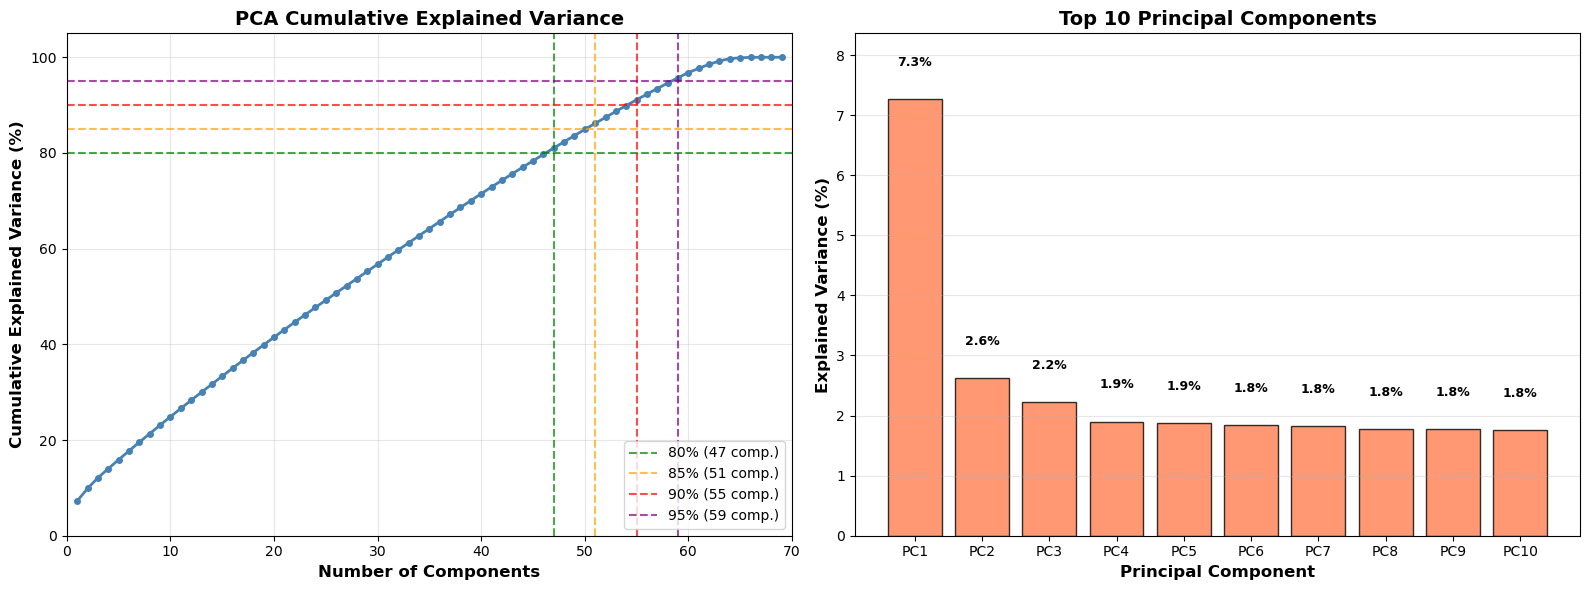

Saved: ../Latex/Figure/pca_explained_variance.png


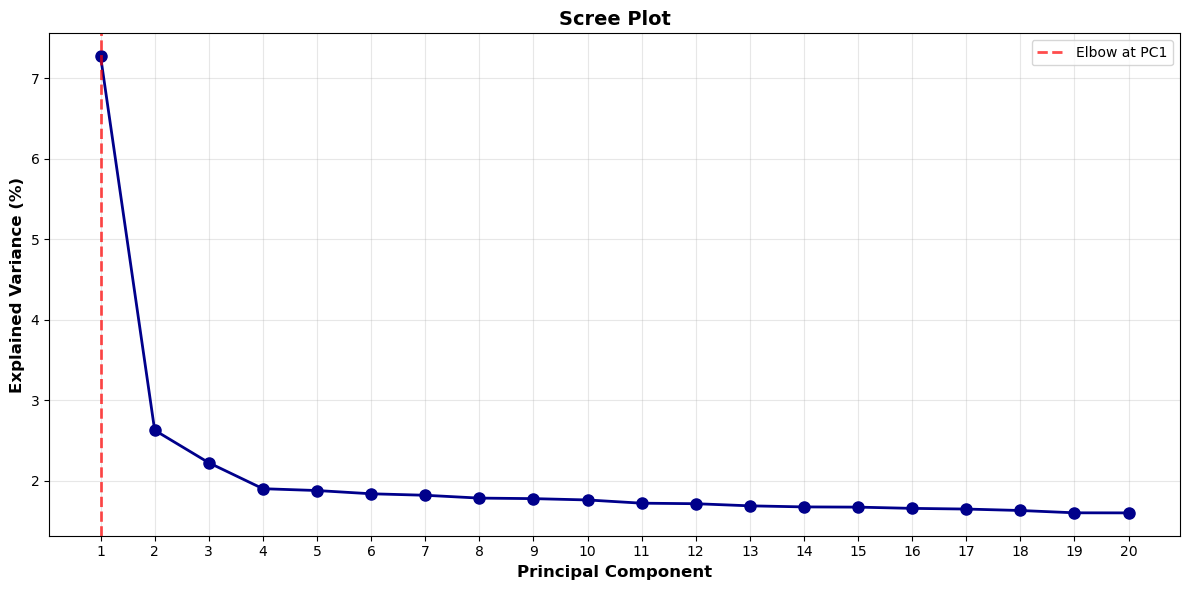

Saved: ../Latex/Figure/pca_scree_plot.png

PC1 (explains 7.27% variance)

Top 10 features:
   1. minutes_played                 + 0.4362
   2. points                         + 0.4248
   3. games                          + 0.4231
   4. total_rebounds                 + 0.3854
   5. assists                        + 0.3676
   6. overall_pick                   - 0.2543
   7. free_throw_percentage          + 0.1692
   8. 3_point_percentage             + 0.1493
   9. field_goal_percentage          + 0.1321
  10. year_normalized                - 0.1057

PC2 (explains 2.63% variance)

Top 10 features:
   1. year_normalized                + 0.4841
   2. college_Other                  - 0.4763
   3. 3_point_percentage             + 0.3187
   4. free_throw_percentage          + 0.2666
   5. college_Kentucky               + 0.2182
   6. college_International          + 0.2003
   7. college_Duke                   + 0.1667
   8. team_CHO                       + 0.1413
   9. team_BRK                  

In [6]:
from Dimension_reduction import Analyzer

# Initialize PCA analyzer
analyzer = Analyzer(
    output_dir='Data/processed',
    figure_dir='../Latex/Figure'
)

# Run complete analysis
analyzer.run_full_analysis(
    X_train=X_train_full,
    X_val=X_val_full,
    feature_names=fe_full.feature_names
)

Total components: 8
Components for 80% variance: 3 (actual: 85.92%)
Components for 85% variance: 3 (actual: 85.92%)
Components for 90% variance: 4 (actual: 92.69%)
Components for 95% variance: 5 (actual: 97.38%)

First 10 components:
  PC1: 57.62% (cumulative: 57.62%)
  PC2: 16.43% (cumulative: 74.05%)
  PC3: 11.87% (cumulative: 85.92%)
  PC4: 6.77% (cumulative: 92.69%)
  PC5: 4.69% (cumulative: 97.38%)
  PC6: 1.52% (cumulative: 98.90%)
  PC7: 0.97% (cumulative: 99.87%)
  PC8: 0.13% (cumulative: 100.00%)


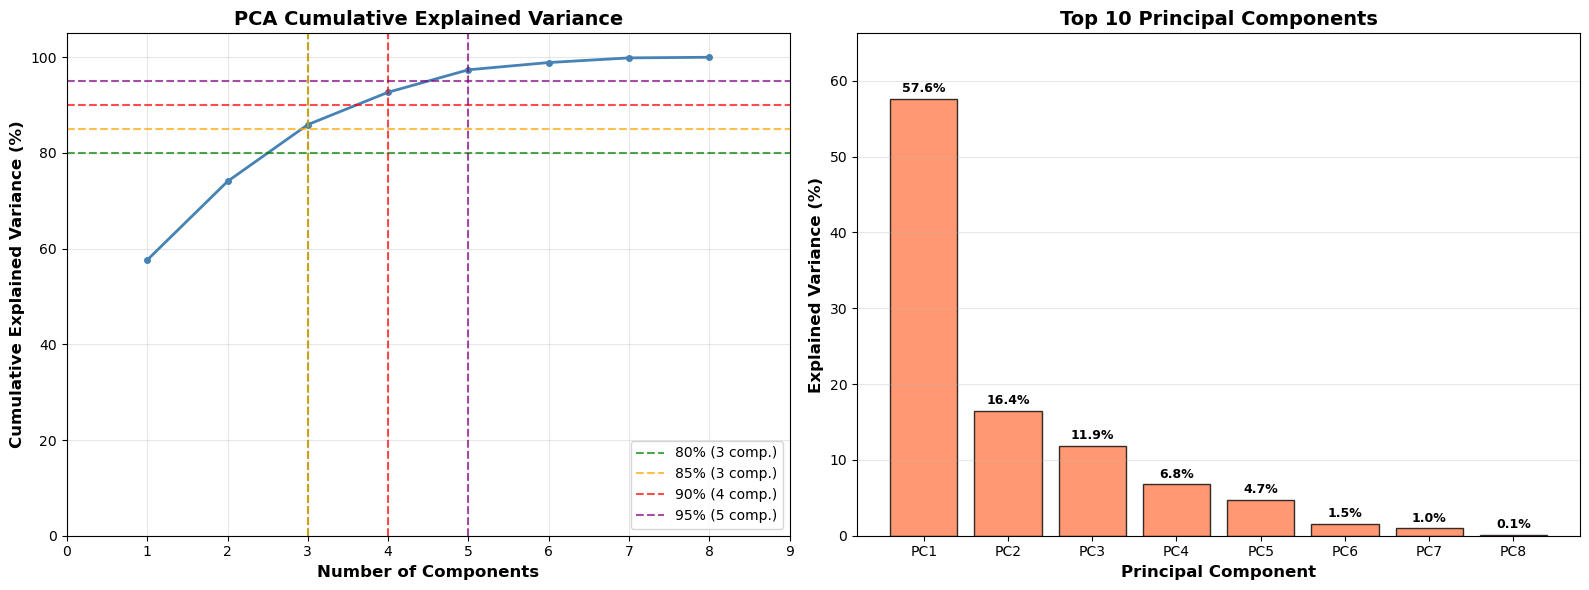

Saved: ../Latex/Figure/pca_explained_variance.png


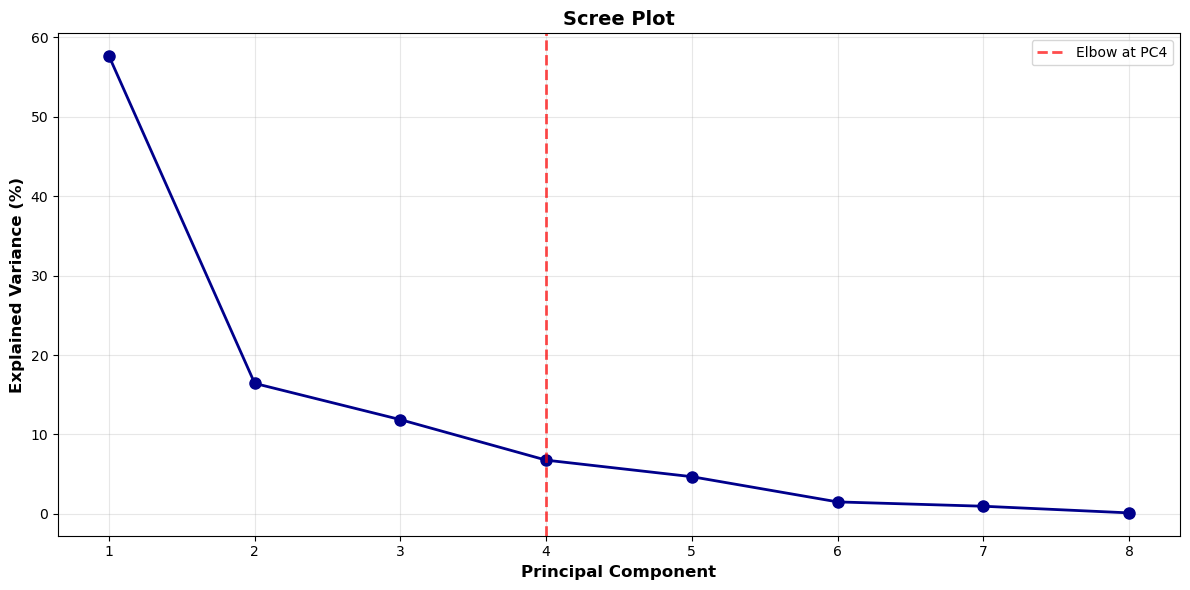

Saved: ../Latex/Figure/pca_scree_plot.png

PC1 (explains 57.62% variance)

Top 10 features:
   1. minutes_played                 + 0.4583
   2. points                         + 0.4473
   3. games                          + 0.4431
   4. total_rebounds                 + 0.4030
   5. assists                        + 0.3907
   6. free_throw_percentage          + 0.1806
   7. 3_point_percentage             + 0.1648
   8. field_goal_percentage          + 0.1369

PC2 (explains 16.43% variance)

Top 10 features:
   1. 3_point_percentage             + 0.6765
   2. free_throw_percentage          + 0.6155
   3. total_rebounds                 - 0.2715
   4. field_goal_percentage          - 0.2679
   5. games                          - 0.0799
   6. minutes_played                 - 0.0775
   7. points                         - 0.0565
   8. assists                        + 0.0503

PC3 (explains 11.87% variance)

Top 10 features:
   1. field_goal_percentage          + 0.9079
   2. free_throw_percentag

In [16]:
analyzer.run_full_analysis(
    X_train=X_train_numeric,
    X_val=X_val_numeric,
    feature_names=fe_numeric.feature_names
)

### 4. Visualize 2D PCA colored by Advanced Metrics

Use numeric-only 2D PCA and color points by quartiles of advanced metrics to understand the data structure.


In [9]:
metric_names = {
    'win_shares': 'Win Shares (WS)',
    'win_shares_per_48_minutes': 'Win Shares per 48 min (WS/48)',
    'box_plus_minus': 'Box Plus/Minus (BPM)',
    'value_over_replacement': 'Value Over Replacement (VORP)'
}

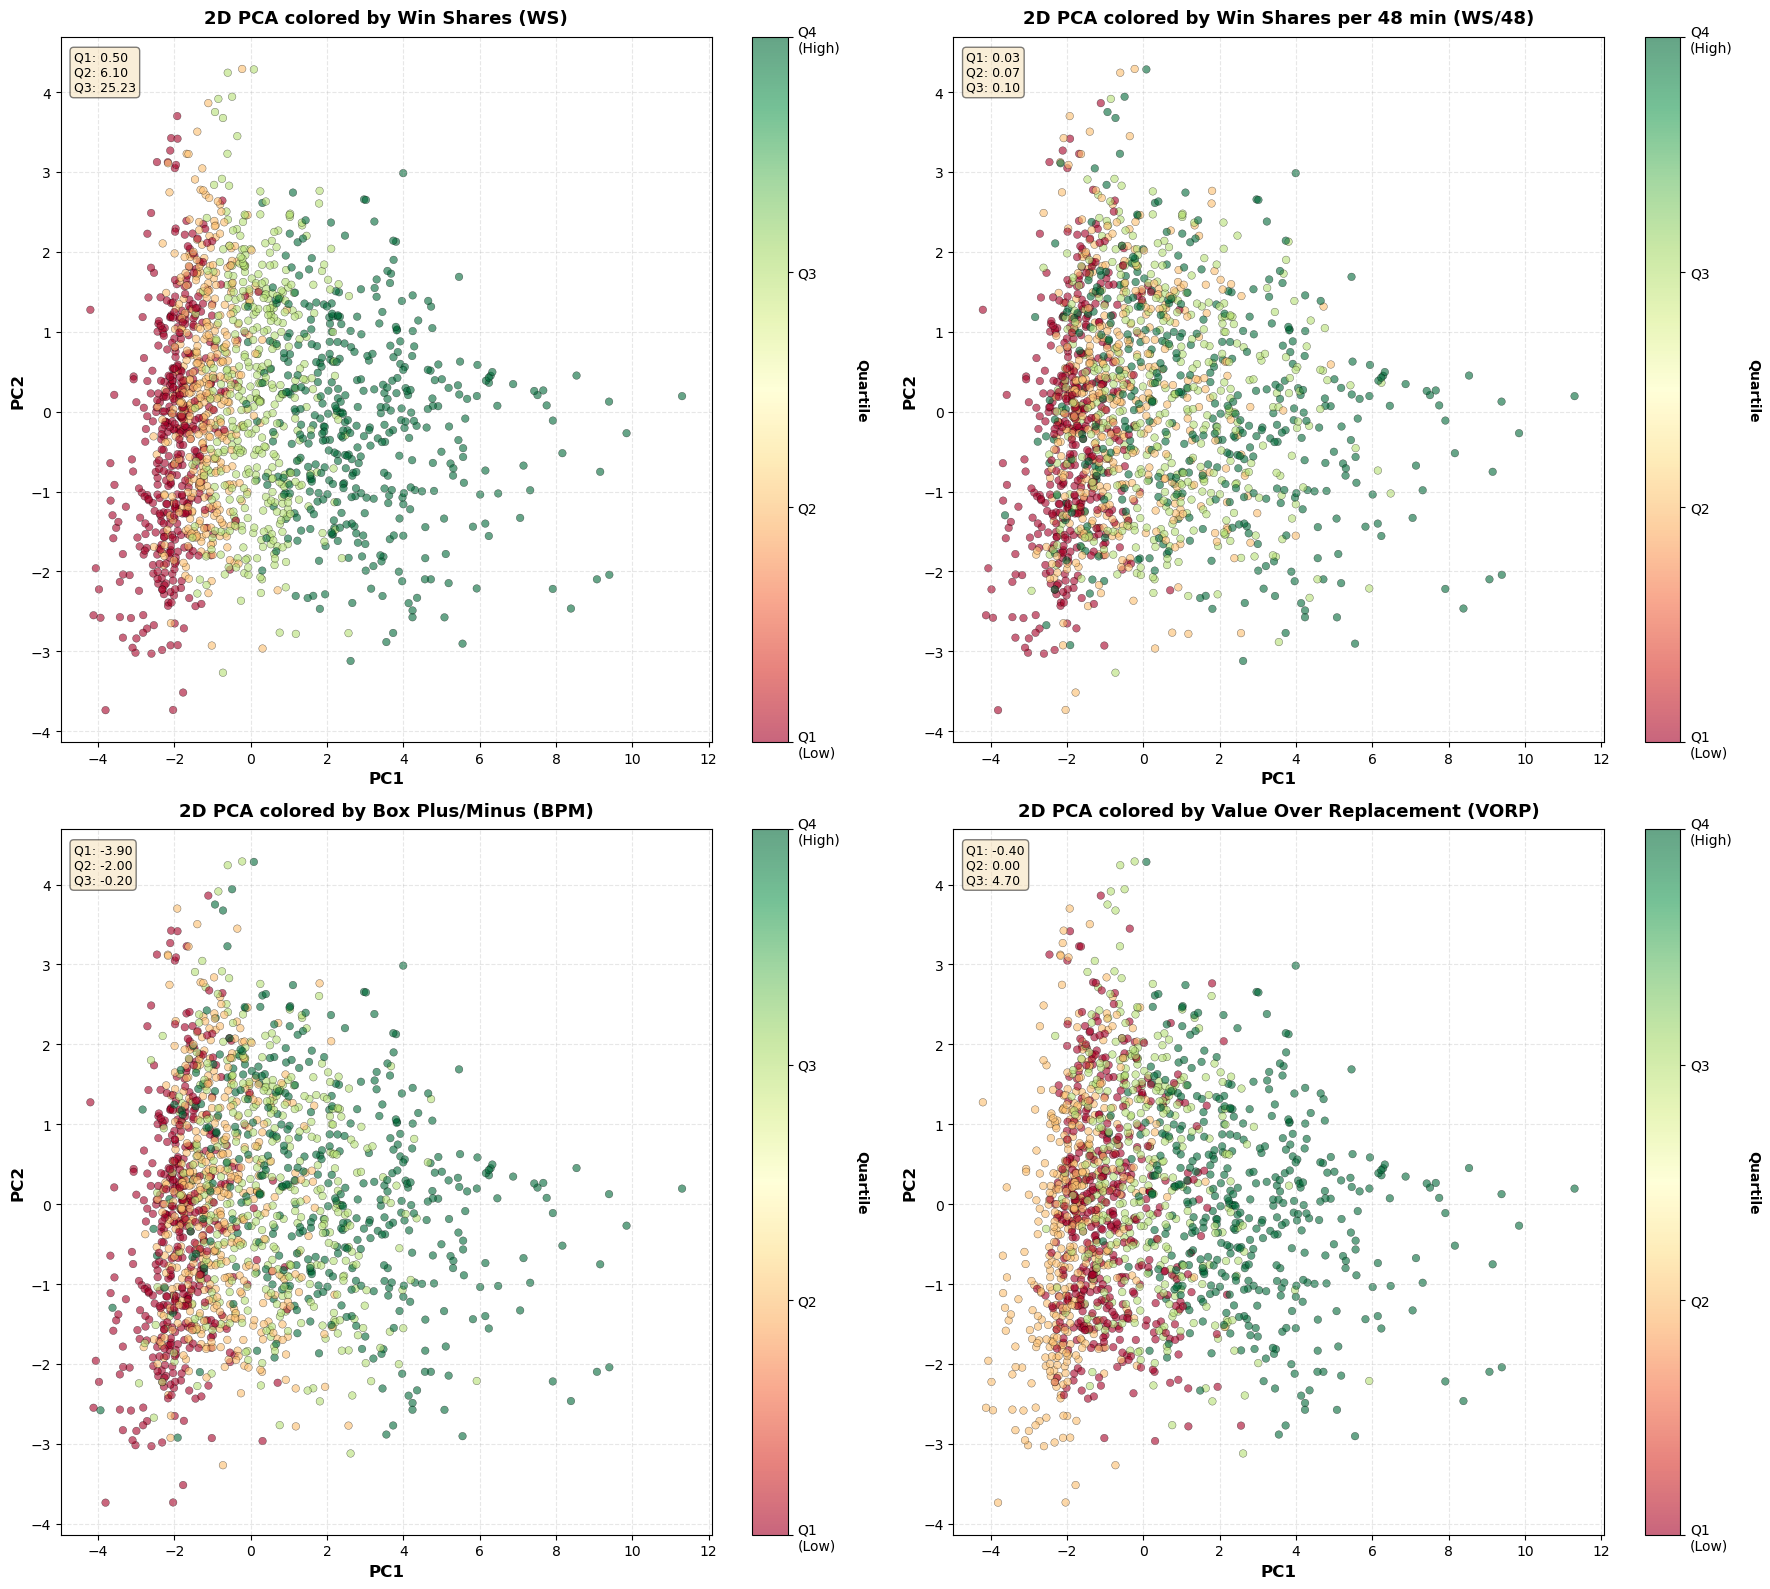


Saved combined figure: ../Latex/Figure/pca_2d_advanced_metrics_quartiles.png


In [11]:
analyzer.plot_2d_colored_by_metrics(
    X_train=X_train_full,
    raw_data=df_train,
    metrics=preprocessor.advanced_metrics,
    metric_names=metric_names,
    save_individual=False
)

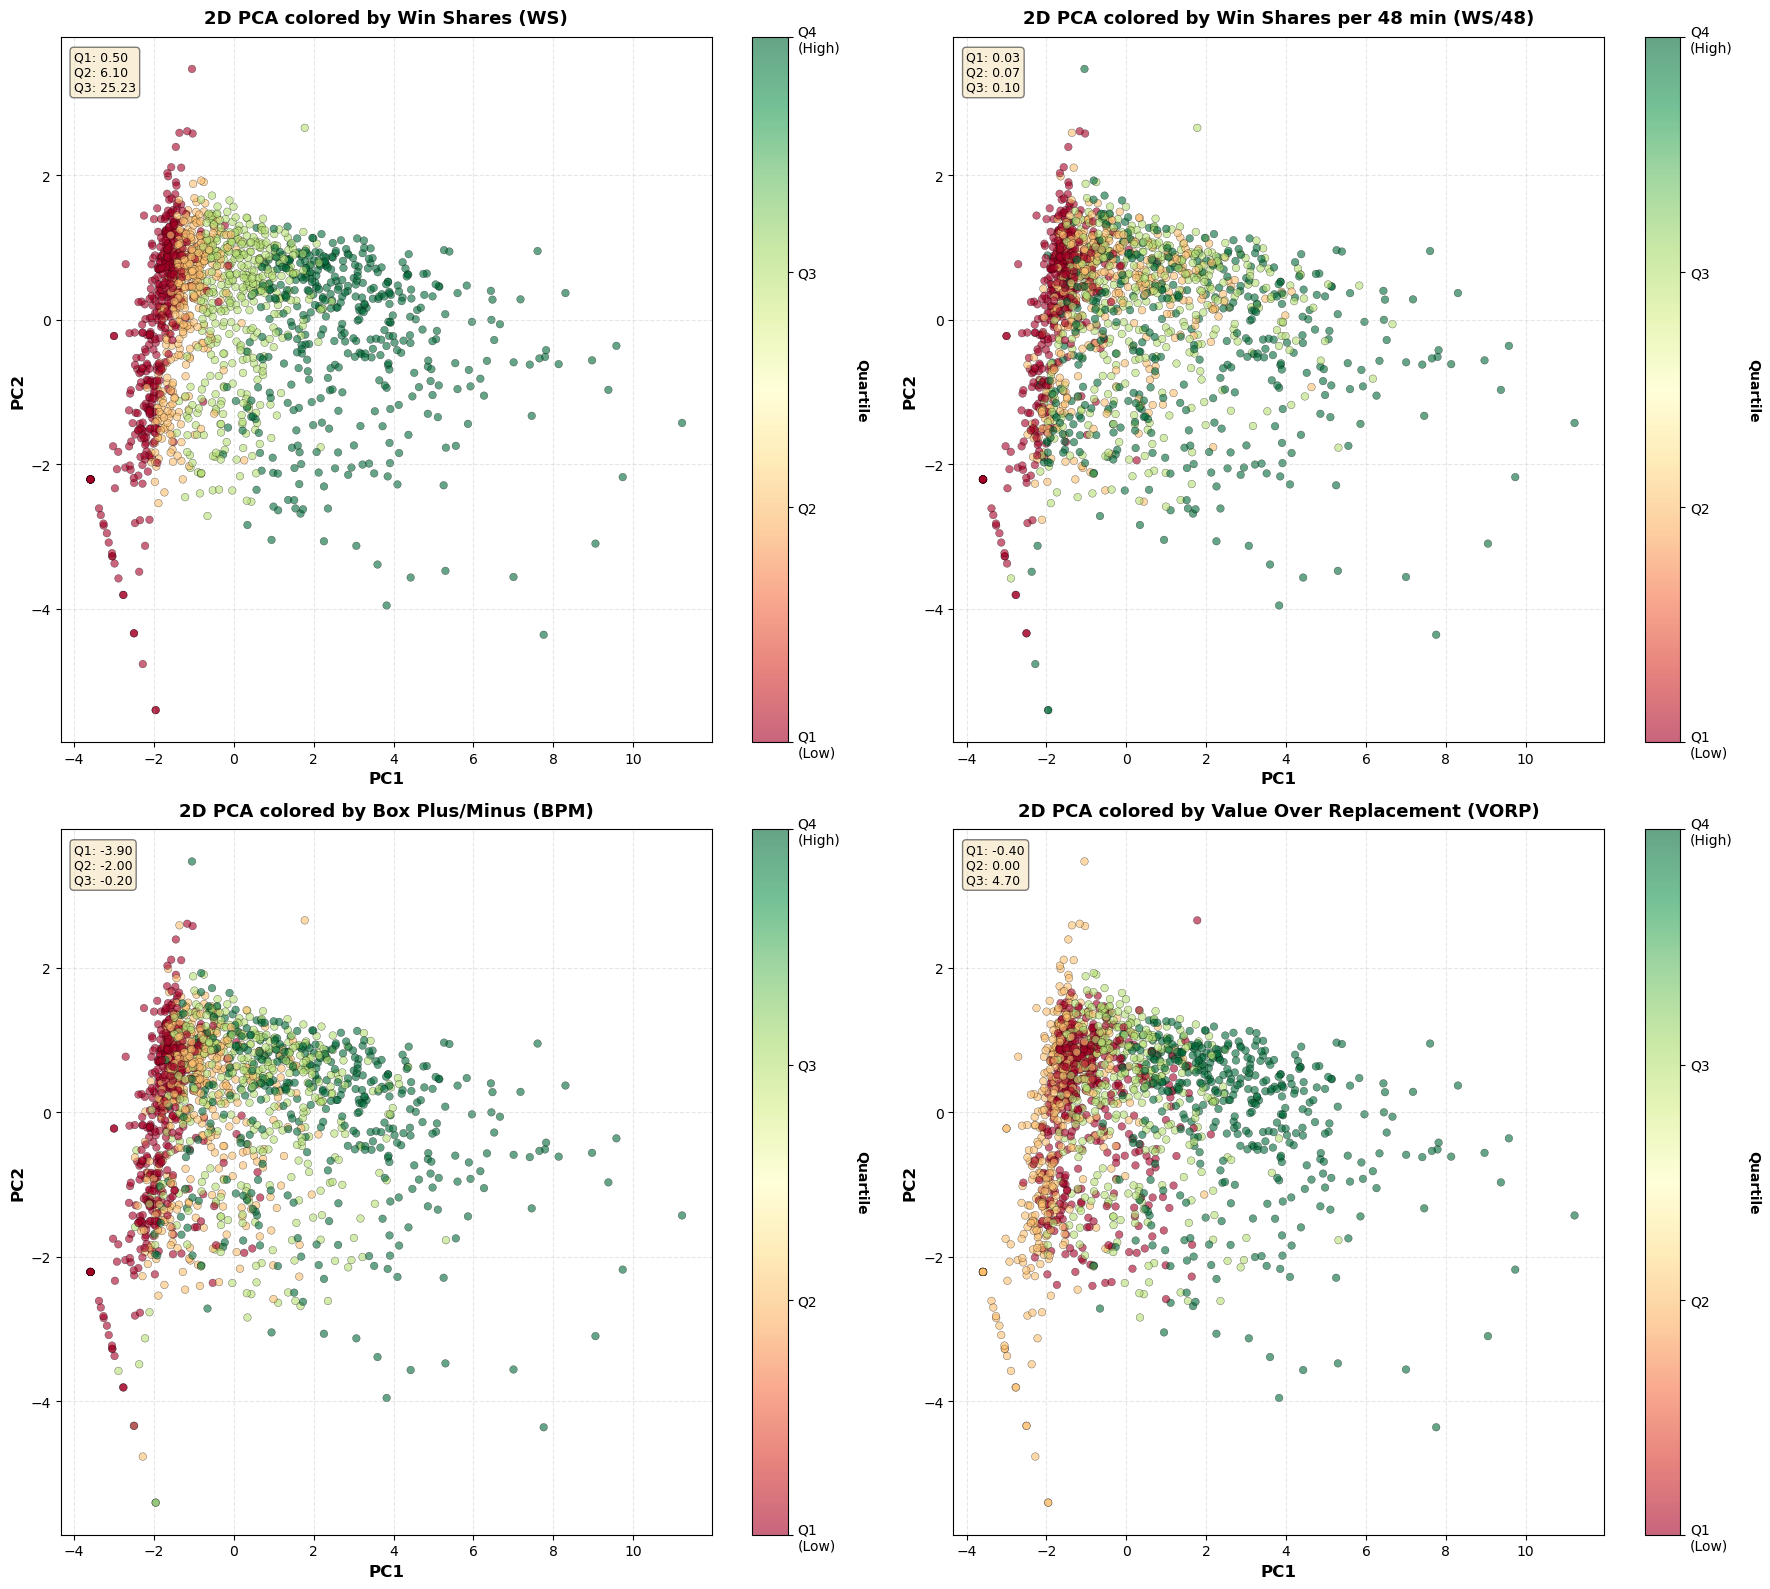


Saved combined figure: ../Latex/Figure/pca_2d_advanced_metrics_quartiles.png


In [17]:
analyzer.plot_2d_colored_by_metrics(
    X_train=X_train_numeric,
    raw_data=df_train,
    metrics=preprocessor.advanced_metrics,
    metric_names=metric_names,
    save_individual=False
)

Found: LeBron James at index 785
Found: Kobe Bryant at index 394
Found: Stephen Curry at index 1148
Found: Kyrie Irving at index 1262
Found: Tim Duncan at index 440
Found: Yao Ming at index 728


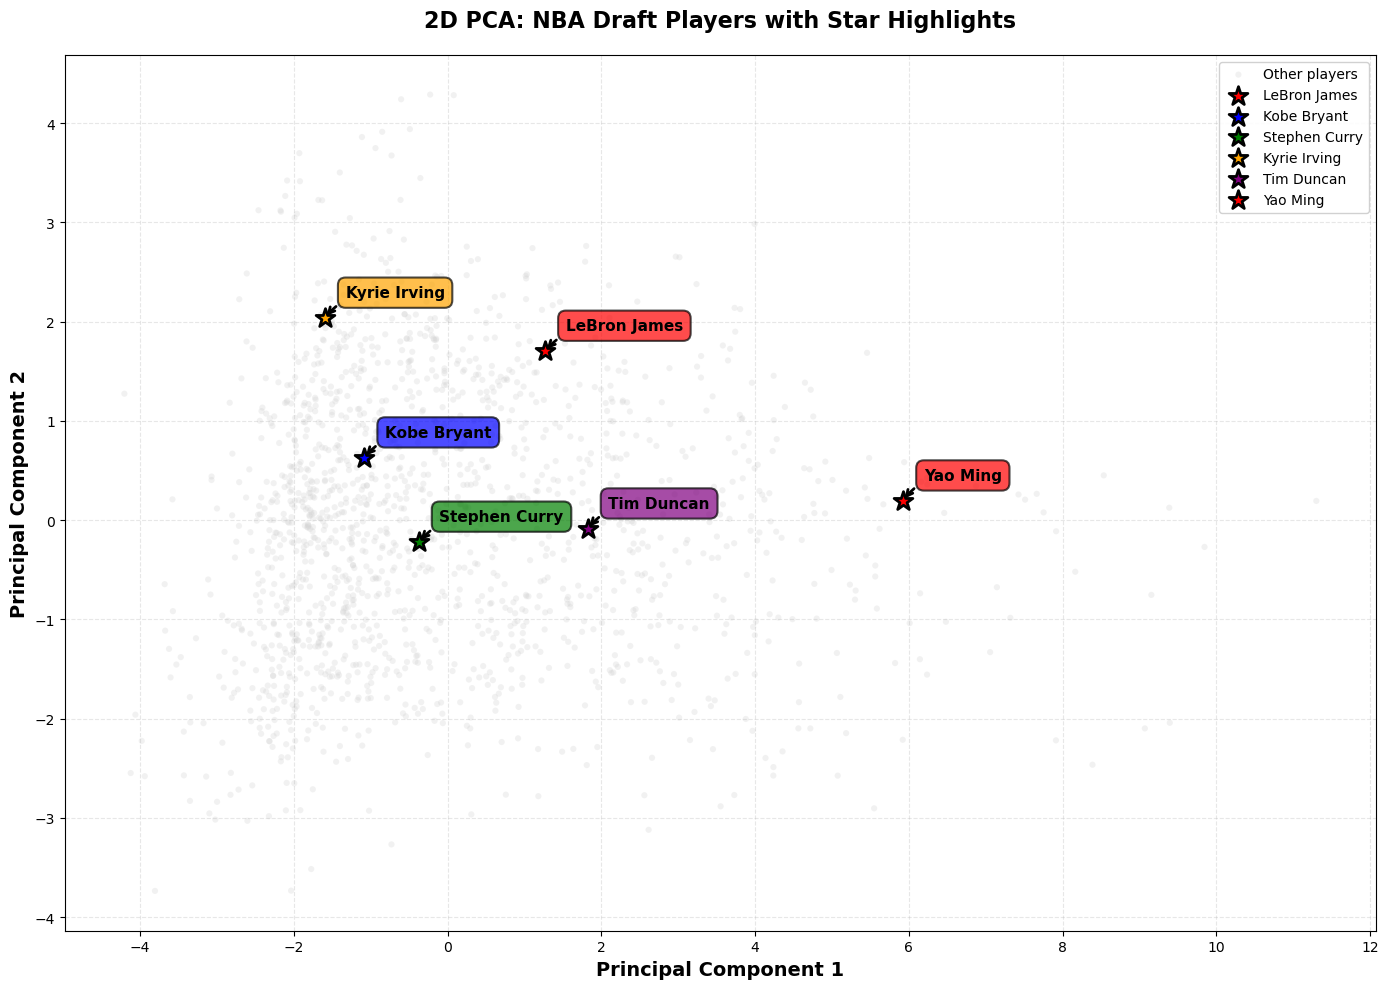


Saved: ../Latex/Figure/pca_2d_star_players.png
Highlighted 6 players: LeBron James, Kobe Bryant, Stephen Curry, Kyrie Irving, Tim Duncan, Yao Ming


In [18]:
# Define star players to highlight
star_players = ['LeBron James', 'Kobe Bryant', 'Stephen Curry', 'Kyrie Irving', 'Tim Duncan',"Yao Ming"]

# Plot with highlights
analyzer.plot_2d_with_player_highlights(
    X_train=X_train_full,
    display_features=df_train[['player', 'year', 'team'] + preprocessor.advanced_metrics],
    player_names=star_players,
    save_name='pca_2d_star_players'
)

### 5. UMAP Analysis

#### Full


UMAP 2D - COLORED BY ADVANCED METRICS
Input shape: (1616, 69)
Parameters: n_neighbors=10, min_dist=0.3


/home/suchuyang/miniconda3/envs/unsupml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1616, 2)


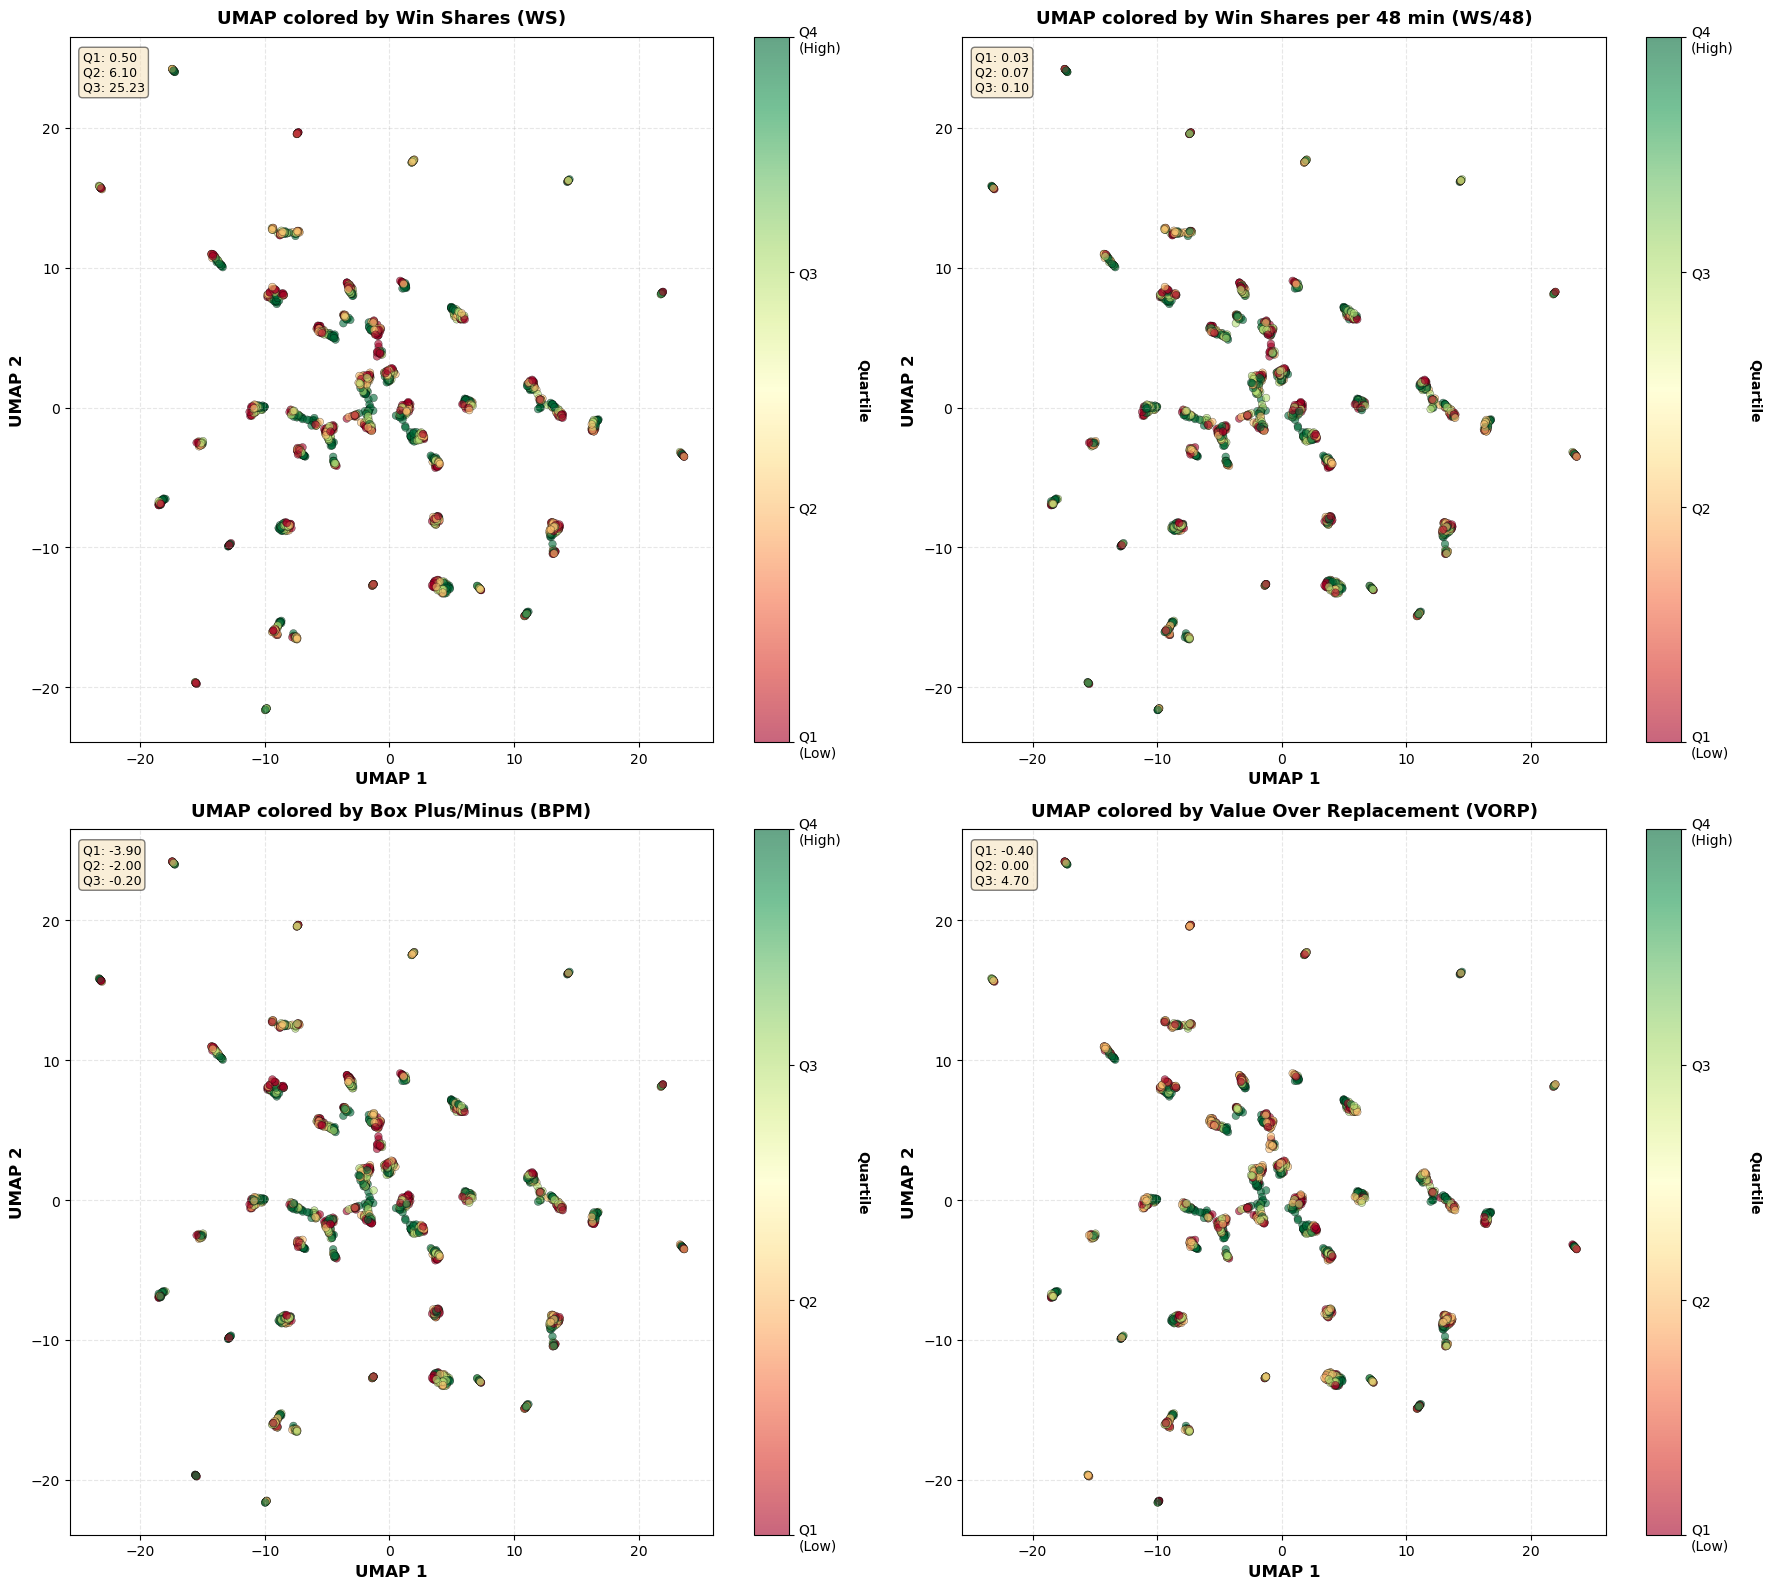


Saved: ../Latex/Figure/umap_2d_advanced_metrics.png

UMAP WITH PLAYER HIGHLIGHTS
Input shape: (1616, 69)


/home/suchuyang/miniconda3/envs/unsupml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1616, 2)
Found: LeBron James at index 785
Found: Kobe Bryant at index 394
Found: Stephen Curry at index 1148
Found: Kyrie Irving at index 1262
Found: Tim Duncan at index 440
Found: Yao Ming at index 728


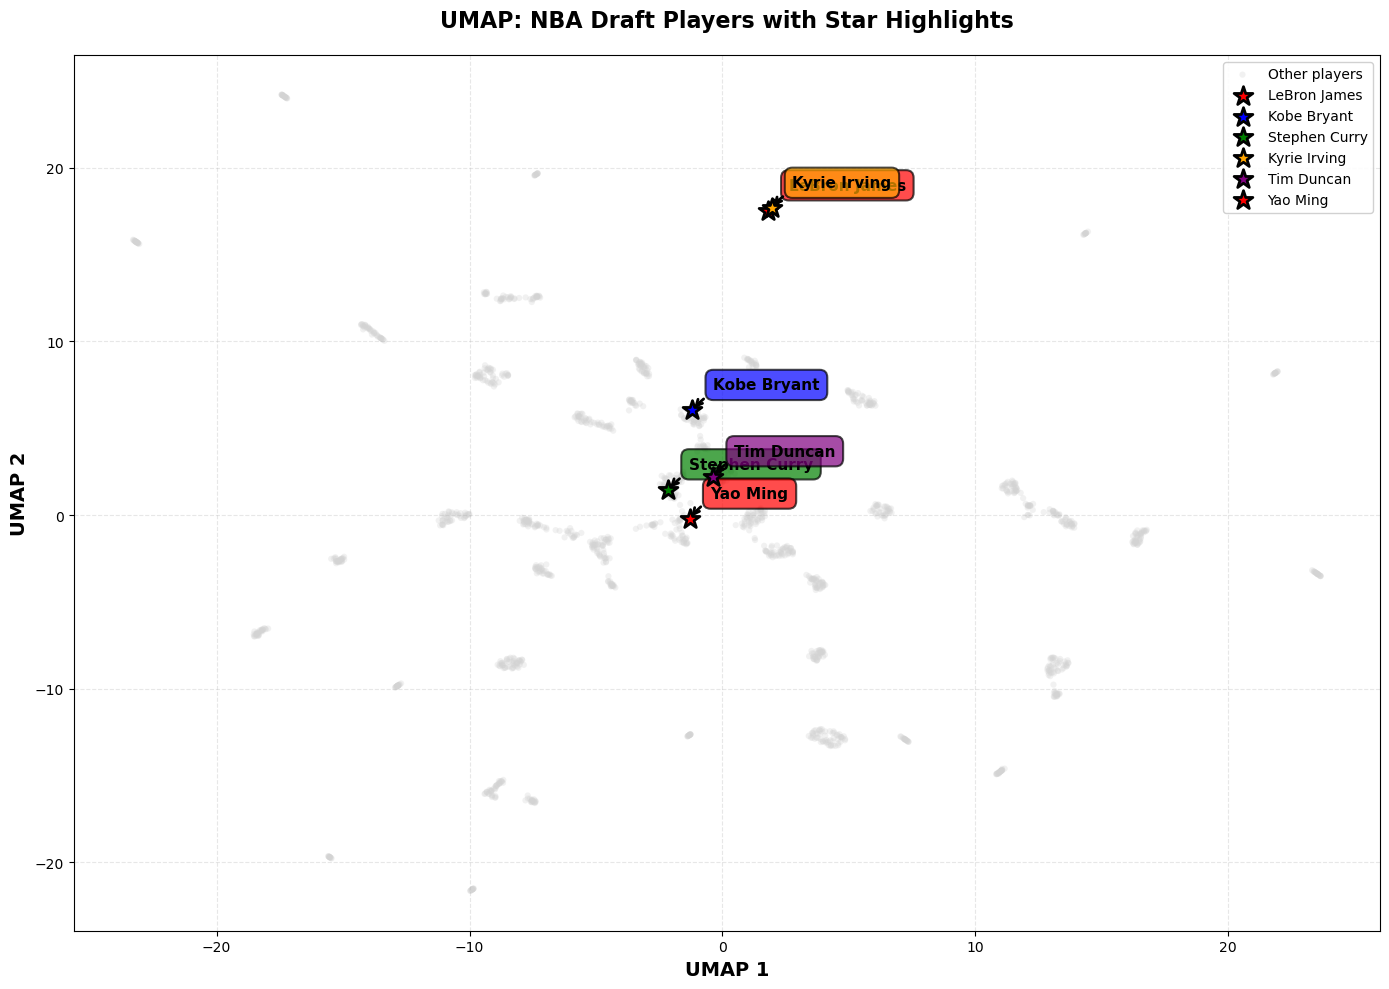


Saved: ../Latex/Figure/umap_2d_star_players.png
Highlighted 6 players: LeBron James, Kobe Bryant, Stephen Curry, Kyrie Irving, Tim Duncan, Yao Ming


array([[ 23.424667 ,  -3.2709868],
       [ 13.325877 ,   0.0489862],
       [  6.2447343,   0.3720118],
       ...,
       [ -1.7140012,  -1.414616 ],
       [-18.341719 ,  -6.8969197],
       [ -7.3973036,  19.59404  ]], shape=(1616, 2), dtype=float32)

In [14]:
# 1. UMAP colored by advanced metrics (4 subplots)
X_umap = analyzer.plot_umap_colored_by_metrics(
    X_train=X_train_full,
    raw_data=df_train,
    metrics=preprocessor.advanced_metrics,
    metric_names=metric_names,
    n_neighbors=10,
    min_dist=0.3
)

# 2. UMAP with star player highlights
analyzer.plot_umap_with_player_highlights(
    X_train=X_train_full,
    display_features=df_train[['player']],
    player_names=star_players,
    n_neighbors=10,
    min_dist=0.3
)

#### Numeric only


UMAP 2D - COLORED BY ADVANCED METRICS
Input shape: (1616, 8)
Parameters: n_neighbors=10, min_dist=0.3


/home/suchuyang/miniconda3/envs/unsupml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1616, 2)


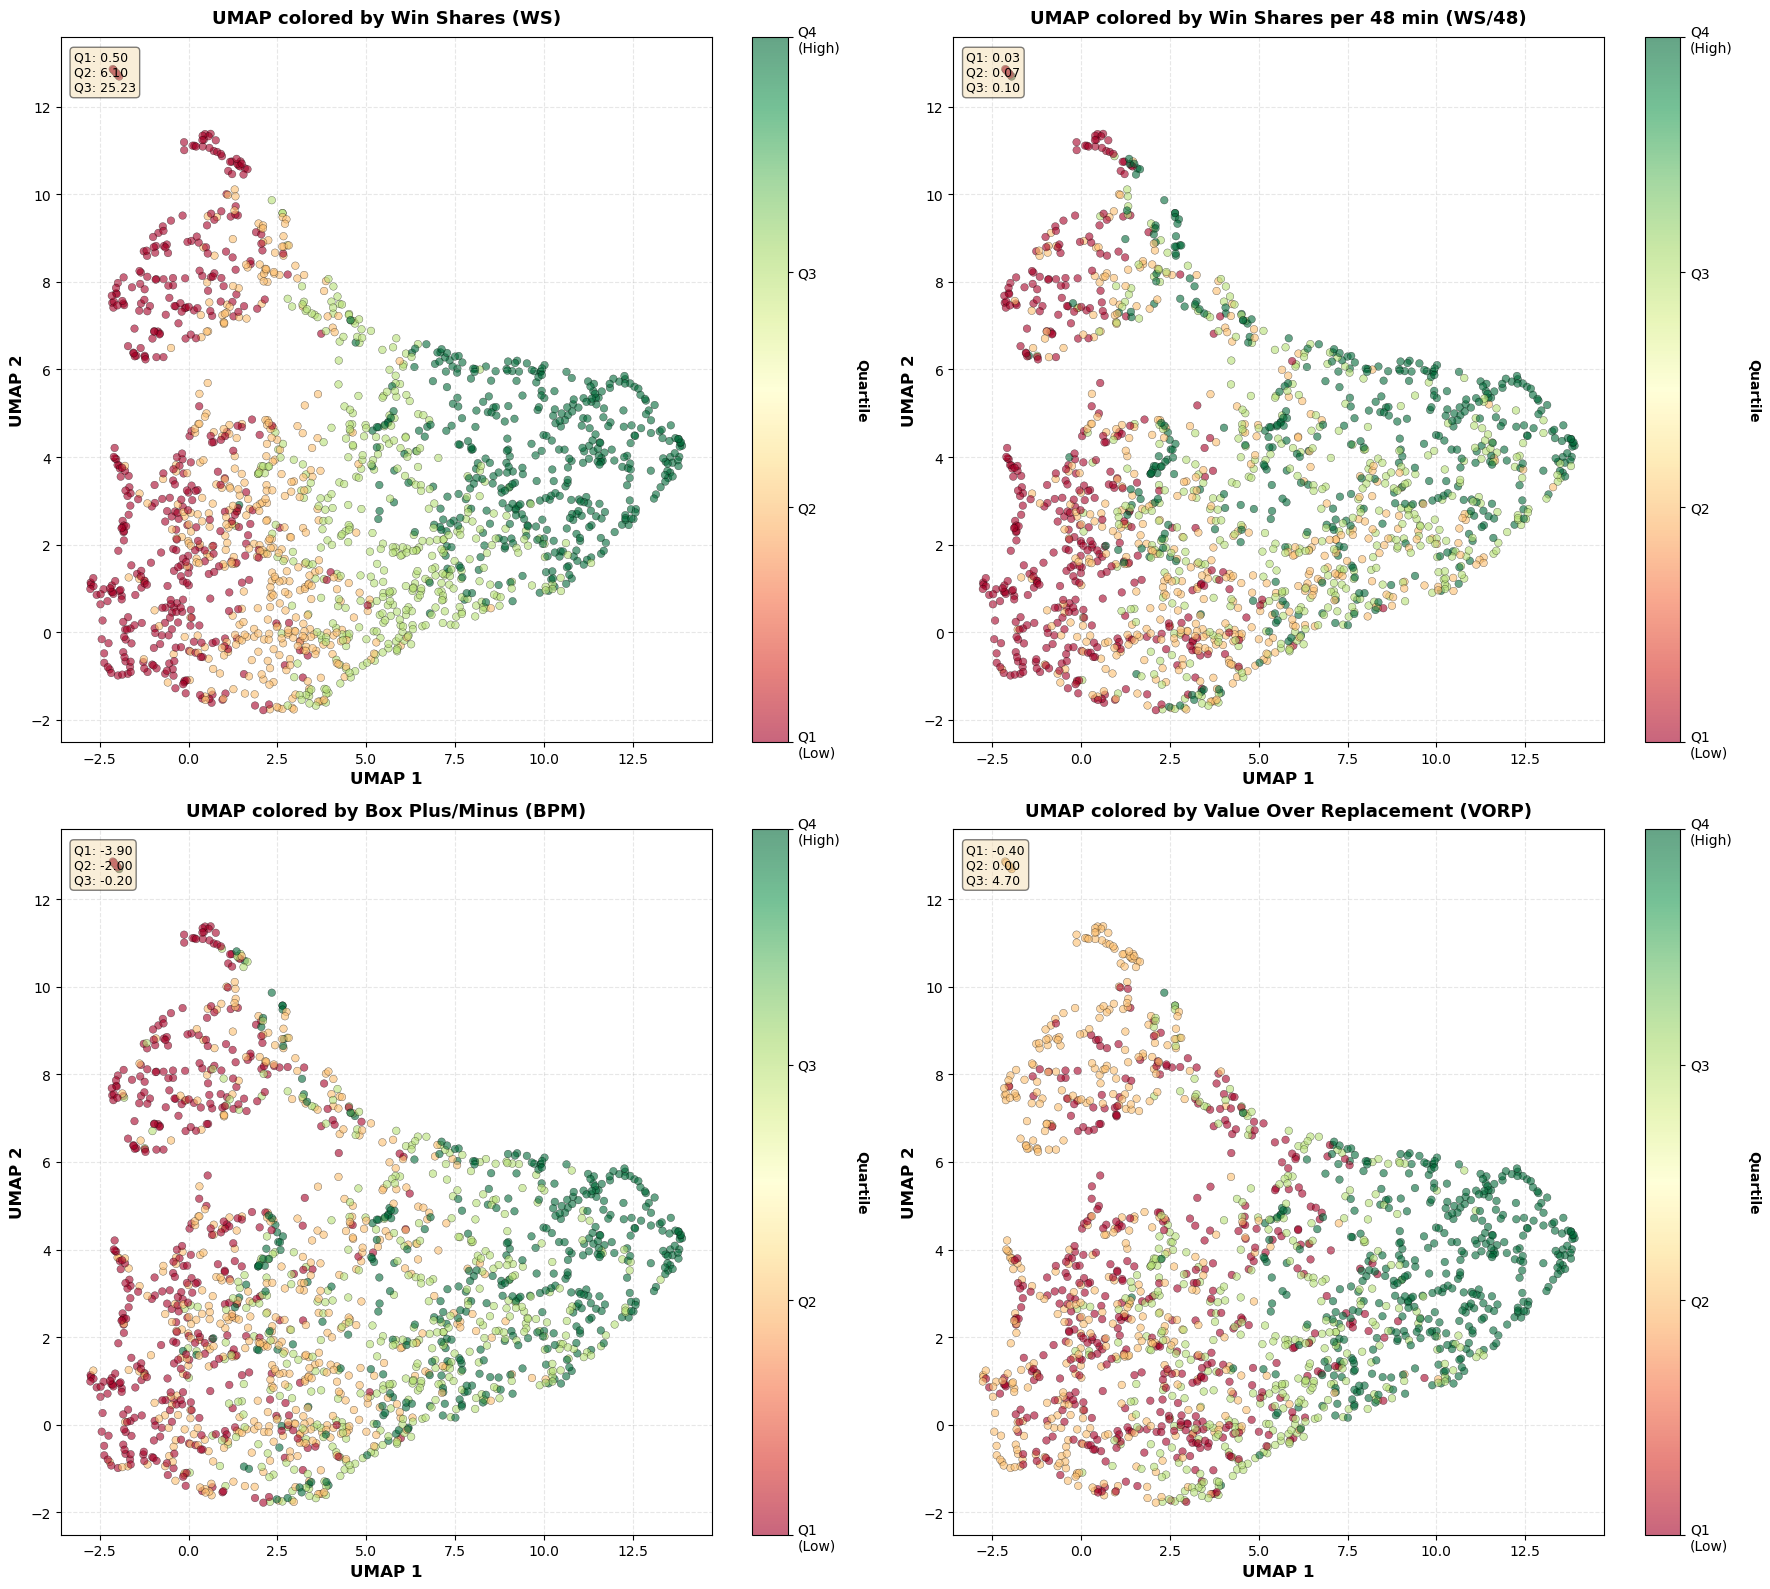


Saved: ../Latex/Figure/umap_2d_advanced_metrics.png

UMAP WITH PLAYER HIGHLIGHTS
Input shape: (1616, 8)


/home/suchuyang/miniconda3/envs/unsupml/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1616, 2)
Found: LeBron James at index 785
Found: Kobe Bryant at index 394
Found: Stephen Curry at index 1148
Found: Kyrie Irving at index 1262
Found: Tim Duncan at index 440
Found: Yao Ming at index 728


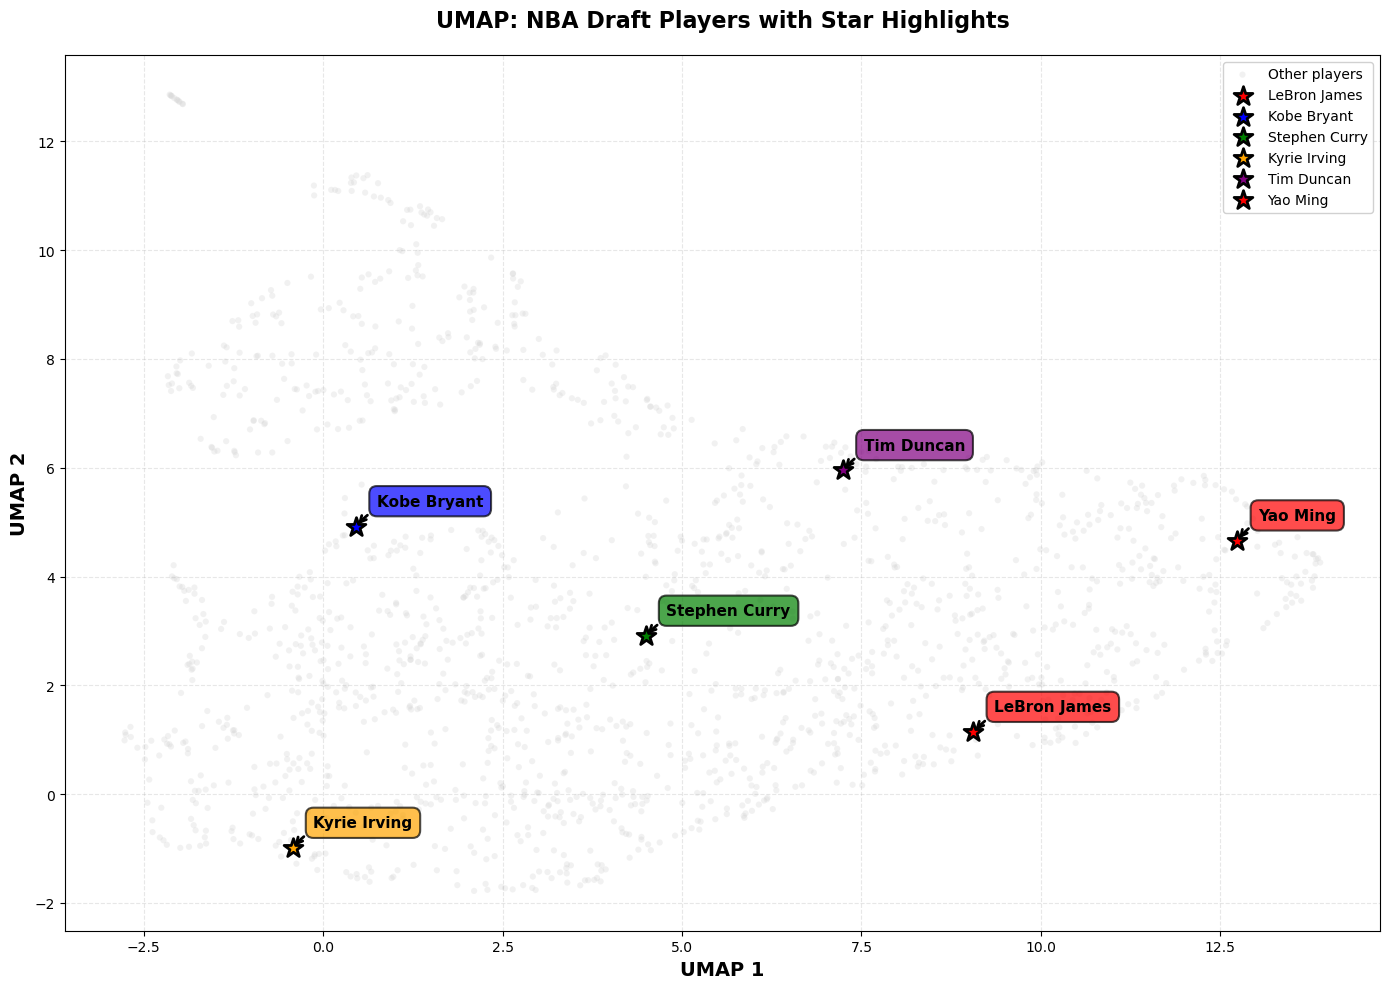


Saved: ../Latex/Figure/umap_2d_star_players.png
Highlighted 6 players: LeBron James, Kobe Bryant, Stephen Curry, Kyrie Irving, Tim Duncan, Yao Ming


array([[ 5.9519296,  5.66701  ],
       [ 9.201617 ,  2.798105 ],
       [10.609691 ,  3.3308666],
       ...,
       [ 2.2572556,  4.7793536],
       [ 1.9704918,  1.7024302],
       [ 1.1375637,  0.4845397]], shape=(1616, 2), dtype=float32)

In [19]:
# 1. UMAP colored by advanced metrics (4 subplots)
X_umap = analyzer.plot_umap_colored_by_metrics(
    X_train=X_train_numeric,
    raw_data=df_train,
    metrics=preprocessor.advanced_metrics,
    metric_names=metric_names,
    n_neighbors=10,
    min_dist=0.3
)

# 2. UMAP with star player highlights
analyzer.plot_umap_with_player_highlights(
    X_train=X_train_numeric,
    display_features=df_train[['player']],
    player_names=star_players,
    n_neighbors=10,
    min_dist=0.3
)